In [998]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from IPython.display import Image

In [999]:
TRAIN_DATASET_PATH = './data/project_task/train.csv' # y_train, y_valid
TEST_DATASET_PATH = './data/project_task/test.csv'

train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

## Анализ данных и предобработка

In [1000]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [1001]:
train_df[['DistrictId', 'Price']].groupby(['DistrictId'], as_index=False).mean().sort_values(by='Price', ascending=False)

,DistrictId,Price
195,195,482791.138606
190,190,471966.746348
181,181,450654.779595
182,182,441284.916612
197,199,432546.129741
...,...,...
58,58,162287.311374
27,27,156046.416277
204,209,140048.802277
158,158,129080.871245


In [1002]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [1003]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [1004]:
train_df[['Rooms', 'Price']].groupby(['Rooms'], as_index=False).mean().sort_values(by='Price', ascending=False)

,Rooms,Price
5,5.0,410431.605679
4,4.0,383251.100956
3,3.0,289337.962452
7,10.0,244797.297328
6,6.0,229661.964416
2,2.0,215256.306416
0,0.0,200435.886261
1,1.0,159850.800729
8,19.0,78364.616704


In [1005]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [1006]:
train_df['Square'].describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

In [1007]:
test_df['Square'].describe()

count    5000.000000
mean       56.449500
std        19.092787
min         1.378543
25%        41.906231
50%        52.921340
75%        66.285129
max       223.453689
Name: Square, dtype: float64

In [1008]:
train_df.loc[train_df['Square'] > 200, ['Square', 'Price']].value_counts()

Square      Price        
200.334539  528560.506016    1
212.932361  302211.260887    1
275.645284  455264.882666    1
409.425181  90470.430830     1
604.705972  187717.242538    1
641.065193  133529.681562    1
dtype: int64

In [1009]:
train_df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [1010]:
train_df.groupby(['Shops_2']).agg({'Price' : ['mean', 'max']})

Price               
                  mean            max
Shops_2                              
A        192339.700513  502523.573863
B        216098.999571  633233.466570

In [1011]:
print(train_df.isna().sum(),"\n", "-" * 20, "\n", test_df.isna().sum())

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64 
 -------------------- 
 Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64


In [1012]:
print(train_df.isna().sum(),"\n", "-" * 20, "\n", test_df.isna().sum())

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64 
 -------------------- 
 Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64


In [1013]:
train_median = train_df['Healthcare_1'].median()
test_median = test_df['Healthcare_1'].median()
train_df['Healthcare_1'].fillna(train_median, inplace=True)
test_df['Healthcare_1'].fillna(test_median, inplace=True)

In [1014]:
print(train_df.isna().sum(),"\n", "-" * 20, "\n", test_df.isna().sum())

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1        0
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64 
 -------------------- 
 Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1        0
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64


In [1015]:
train_df = train_df.round().astype(int, errors='ignore')
test_df = test_df.round().astype(int, errors='ignore')

In [1016]:
print(train_df.describe(include=['O']), "\n", "-" * 50, "\n", test_df.describe(include=['O']))

       Ecology_2 Ecology_3 Shops_2
count      10000     10000   10000
unique         2         2       2
top            B         B       B
freq        9903      9725    9175 
 -------------------------------------------------- 
        Ecology_2 Ecology_3 Shops_2
count       5000      5000    5000
unique         2         2       2
top            B         B       B
freq        4952      4851    4588


In [1017]:
object_mapping = {"A": 0, "B": 1}
columns = ["Ecology_2", "Ecology_3", "Shops_2"]
for col in columns:
  train_df[col] = train_df[col].map(object_mapping)
for col in columns:
  test_df[col] = test_df[col].map(object_mapping)

In [1018]:
train_df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.0,NaN,10.0,4,10.0,2014,0.0,1,1,11,3097,0,900.0,0,0,1,305019.0
1,3013,22,1.0,40.0,23.0,8.0,7,8.0,1966,0.0,1,1,30,6207,1,1183.0,1,0,1,177735.0
2,8215,1,3.0,78.0,48.0,10.0,2,17.0,1988,0.0,1,1,33,5261,0,240.0,3,1,1,282079.0
3,2352,1,1.0,40.0,NaN,1.0,10,22.0,1977,0.0,1,1,1,264,0,900.0,0,1,1,168106.0
4,13866,94,2.0,64.0,39.0,9.0,16,16.0,1972,0.0,1,1,33,8667,2,900.0,0,6,1,343995.0


In [1019]:
train_df['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1928           1
1947           1
1914           1
4968           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

### Обработка выбросов

In [1020]:
def edit_df(df):
    """ Замена пустых значений и обработка выбросов """
    df['LifeSquare'].fillna(df['Square'] / 1.6228, inplace=True)
    
    train_df.drop(train_df[train_df['LifeSquare'] > 150].index, inplace=True)
    train_df.drop(train_df[train_df['Square'] <= 10].index, inplace=True)
    train_df.drop(train_df[train_df['Rooms'] >= 6].index, inplace=True)
    train_df.drop(train_df[train_df['Rooms'] == 0.0].index, inplace=True)
    
    test_df['Rooms'].loc[test_df['Rooms'] > 5] = 5
    test_df['Rooms'].loc[test_df['Rooms'] == 0] = 1
    test_df['Square'].loc[test_df['Square'] <= 14] = 14
    test_df['Square'].loc[test_df['Square'] >= 200] = 199

    df['LifeSquare'].loc[df['LifeSquare'] >= df['Square']] = (df['Square'] / 1.6228).round().astype(int)
    df['LifeSquare'].loc[df['Square'] >= (df['LifeSquare'] * 2)] = (df['Square'] / 1.6228).round().astype(int)
    df.loc[df['LifeSquare'] <= 10, 'Rooms'] = 1
    
    df['KitchenSquare'].loc[df['KitchenSquare'] >= df['Square']] = (df['Square'] / 9).round().astype(int)
    df['KitchenSquare'].loc[df['Square'] >= (df['KitchenSquare'] * 10)] = (df['Square'] / 9).round().astype(int)
    
    df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = int(df['HouseFloor'].median())
    df['Floor'].loc[df['Floor'] > df['HouseFloor']] = (df['HouseFloor'] / 2).round().astype(int)
    
    df['HouseYear'].loc[df['HouseYear'] > 2020] = 2020
    df['HouseYear'].loc[df['HouseYear'] < 1910] = 1910

edit_df(train_df)
edit_df(test_df)


In [1021]:
train_df['HouseYear'].describe()

count    9962.000000
mean     1984.848223
std        18.410490
min      1910.000000
25%      1974.000000
50%      1977.000000
75%      2001.000000
max      2020.000000
Name: HouseYear, dtype: float64

In [1022]:
test_df['HouseYear'].describe()

count    5000.000000
mean     1984.393200
std        18.570718
min      1910.000000
25%      1973.000000
50%      1977.000000
75%      2000.000000
max      2020.000000
Name: HouseYear, dtype: float64

In [1023]:
def house_band(df):
    df['HouseBand'] = df['HouseYear'] // 10 * 10
house_band(train_df)
house_band(test_df)
med_price_by_house_year = train_df.groupby(['HouseBand', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByHouseYear'})

train_df = train_df.merge(med_price_by_house_year, on=['HouseBand', 'Rooms'], how='left')
test_df = test_df.merge(med_price_by_house_year, on=['HouseBand', 'Rooms'], how='left')
test_df['MedPriceByHouseYear'].fillna(test_df['MedPriceByHouseYear'].median(), inplace=True)
train_df.pop('HouseBand')
test_df.pop('HouseBand')

0       1970
1       2010
2       1970
3       1960
4       1970
        ... 
4995    1960
4996    2010
4997    1960
4998    1970
4999    2000
Name: HouseBand, Length: 5000, dtype: int32

In [1024]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,MedPriceByHouseYear
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,8412.595400,51.279200,1.907400,56.463400,36.179884,7.731200,7.374600,12.915400,1984.393200,0.005000,0.990400,0.970200,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800,0.917600,205028.721900
std,4832.674037,44.179466,0.809788,18.982179,13.664400,3.173856,5.101557,6.468617,18.570718,0.070541,0.097518,0.170052,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365,0.275001,61785.588655
min,1.000000,0.000000,1.000000,14.000000,9.000000,2.000000,0.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000,136202.000000
25%,4221.750000,21.000000,1.000000,42.000000,25.881193,6.000000,4.000000,9.000000,1973.000000,0.000000,1.000000,1.000000,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000,1.000000,157112.000000
50%,8320.500000,37.000000,2.000000,53.000000,33.000000,7.000000,6.000000,12.000000,1977.000000,0.000000,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,1.000000,189183.000000
75%,12598.250000,77.000000,2.000000,66.000000,44.000000,9.000000,10.000000,17.000000,2000.000000,0.000000,1.000000,1.000000,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000,1.000000,238120.000000
max,16795.000000,212.000000,5.000000,199.000000,137.000000,65.000000,46.000000,99.000000,2020.000000,1.000000,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000,536431.500000


### Понижение размерности и визуализация

In [1025]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    file = reduce_mem_usage(file)
    return file

import_data(train_df)
import_data(test_df)

Memory usage of dataframe is 1.33 MB
Memory usage after optimization is: 0.45 MB
Decreased by 66.4%
Memory usage of dataframe is 0.63 MB
Memory usage after optimization is: 0.21 MB
Decreased by 67.4%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,MedPriceByHouseYear
0,4567,44,1.0,37.0,19.00000,5.0,5,9.0,1970,0.0,1,1,24,4378,0,1036.0,1,1,1,141496.0
1,5925,62,1.0,42.0,26.00000,10.0,7,17.0,2017,0.0,1,1,2,629,1,900.0,0,0,0,136202.0
2,960,27,2.0,59.0,36.34375,9.0,19,19.0,1977,0.0,1,1,9,1892,0,900.0,0,1,1,189183.0
3,3848,23,3.0,50.0,34.00000,6.0,2,2.0,1965,0.0,1,1,2,475,0,900.0,0,0,1,262780.0
4,746,74,1.0,54.0,33.28125,6.0,8,17.0,1977,0.0,1,1,35,7715,4,990.0,0,6,1,141496.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.0,30.00000,5.0,2,5.0,1962,0.0,1,1,31,6119,4,900.0,1,2,1,194175.0
4996,16138,38,3.0,94.0,58.00000,10.0,21,27.0,2018,0.0,1,1,15,2787,2,520.0,0,7,1,232208.0
4997,3912,101,1.0,34.0,19.00000,5.0,2,5.0,1966,0.0,1,1,28,6533,1,1015.0,2,5,1,157112.0
4998,5722,10,1.0,39.0,21.00000,9.0,8,14.0,1970,0.0,1,1,33,7976,5,900.0,0,11,1,141496.0


In [1026]:
train_df.dtypes, test_df.dtypes

(Id                       int16
 DistrictId               int16
 Rooms                  float16
 Square                 float16
 LifeSquare             float16
 KitchenSquare          float16
 Floor                     int8
 HouseFloor             float16
 HouseYear                int16
 Ecology_1              float16
 Ecology_2                 int8
 Ecology_3                 int8
 Social_1                  int8
 Social_2                 int16
 Social_3                 int16
 Healthcare_1           float16
 Helthcare_2               int8
 Shops_1                   int8
 Shops_2                   int8
 Price                  float32
 MedPriceByHouseYear    float32
 dtype: object,
 Id                       int16
 DistrictId               int16
 Rooms                  float16
 Square                 float16
 LifeSquare             float16
 KitchenSquare          float16
 Floor                     int8
 HouseFloor             float16
 HouseYear                int16
 Ecology_1              

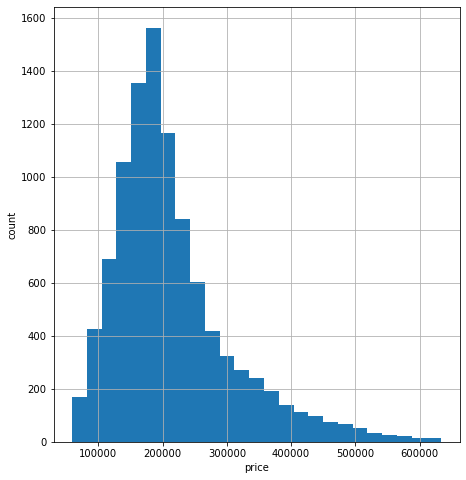

In [1027]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist(density=False, bins=25)
plt.ylabel('count')
plt.xlabel('price')
plt.show()

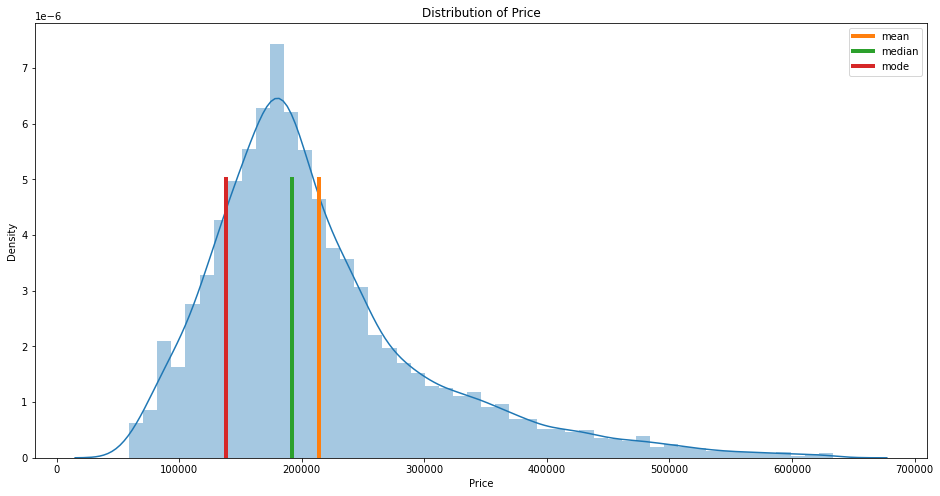

In [1028]:
plt.figure(figsize = (16, 8))
target_mean= round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]

sns.distplot(train_df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

In [1029]:
target_bins = train_df['Price'] // 10000 * 10000

target_adjusted_mode = target_bins.mode()[0]
target_adjusted_mode

180000.0

In [1030]:
target_bins.value_counts().iloc[:10]

180000.0    738
170000.0    672
160000.0    613
190000.0    596
150000.0    542
200000.0    514
140000.0    494
210000.0    465
130000.0    433
220000.0    371
Name: Price, dtype: int64

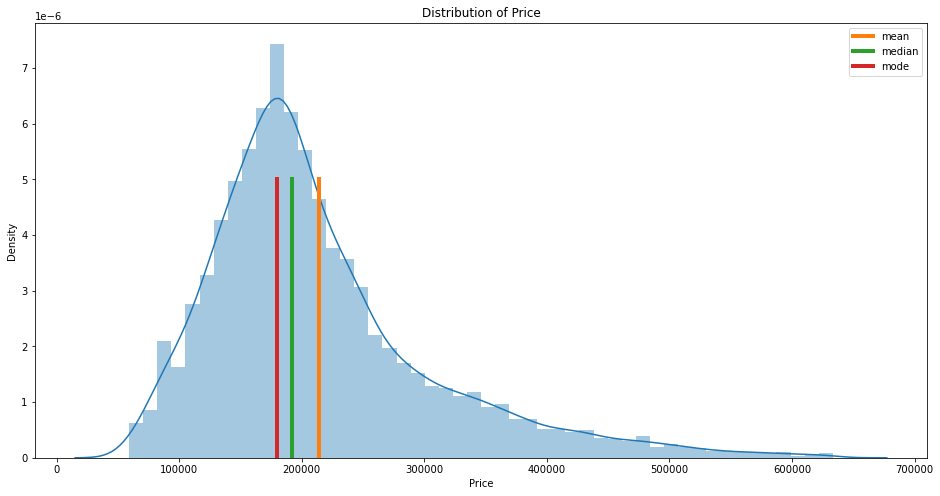

In [1031]:
plt.figure(figsize = (16, 8))
target_mean= round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]

sns.distplot(train_df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linewidth=4)
plt.plot([target_adjusted_mode] * 10, y, label='mode', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

In [1032]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByHouseYear
0,11809,27,3.0,115.0,70.87500,13.0,4,10.0,2014,0.0,...,1,11,3097,0,900.0,0,0,1,305019.0,232208.0
1,3013,22,1.0,40.0,23.00000,8.0,7,8.0,1966,0.0,...,1,30,6207,1,1183.0,1,0,1,177735.0,157112.0
2,8215,1,3.0,78.0,48.00000,10.0,2,17.0,1988,0.0,...,1,33,5261,0,240.0,3,1,1,282079.0,319240.0
3,2352,1,1.0,40.0,24.65625,4.0,10,22.0,1977,0.0,...,1,1,264,0,900.0,0,1,1,168106.0,141496.0
4,13866,94,2.0,64.0,39.00000,9.0,16,16.0,1972,0.0,...,1,33,8667,2,900.0,0,6,1,343995.0,189183.0


<AxesSubplot:>

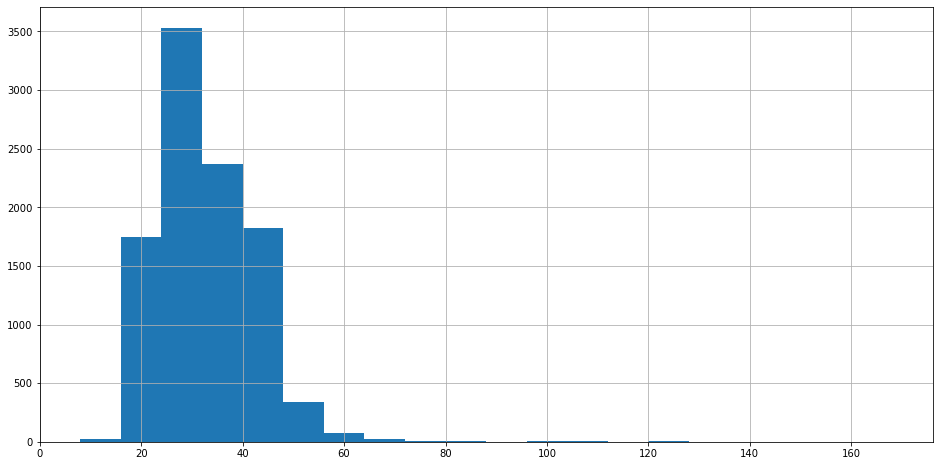

In [1033]:
square_per_room = train_df['Square'] / train_df['Rooms']
square_per_room.hist(figsize=(16,8), bins=20, grid=True)

### Дополнительная обработка данных и Feature Engineering

In [1034]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByHouseYear
count,9962.000000,9962.000000,9962.000000,9962.000000,9962.000000,9962.0000,9962.00000,9962.000000,9962.000000,9962.000000,...,9962.000000,9962.000000,9962.000000,9962.000000,9962.0,9962.000000,9962.000000,9962.000000,9962.000000,9962.00000
mean,8381.156093,50.446798,1.886719,inf,inf,inf,7.27364,inf,1984.848223,0.003914,...,0.972495,24.705380,5355.262196,8.019876,inf,1.319815,4.228569,0.917286,214020.359375,204543.09375
std,4858.222895,43.615599,0.810547,18.640625,13.664062,3.6875,5.01014,6.433594,18.410490,0.062439,...,0.163556,17.523184,4004.585391,23.761363,inf,1.493589,4.798568,0.275464,92692.601562,61934.87500
min,0.000000,0.000000,1.000000,14.000000,9.000000,2.0000,0.00000,1.000000,1910.000000,0.000000,...,0.000000,0.000000,168.000000,0.000000,0.0,0.000000,0.000000,0.000000,59175.000000,136202.00000
25%,4167.250000,20.000000,1.000000,42.000000,25.875000,6.0000,4.00000,9.000000,1974.000000,0.000000,...,1.000000,6.000000,1564.000000,0.000000,830.0,0.000000,1.000000,1.000000,153887.250000,157112.00000
50%,8392.500000,36.000000,2.000000,53.000000,33.000000,7.0000,6.00000,13.000000,1977.000000,0.000000,...,1.000000,25.000000,5285.000000,2.000000,900.0,1.000000,3.000000,1.000000,192153.000000,189183.00000
75%,12589.750000,75.000000,2.000000,66.000000,44.000000,9.0000,10.00000,17.000000,2001.000000,0.000000,...,1.000000,36.000000,7227.000000,5.000000,990.0,2.000000,6.000000,1.000000,249095.500000,238120.00000
max,16798.000000,209.000000,5.000000,199.000000,138.000000,112.0000,42.00000,117.000000,2020.000000,1.000000,...,1.000000,74.000000,19083.000000,141.000000,4848.0,6.000000,23.000000,1.000000,633233.000000,536431.50000


In [1035]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,MedPriceByHouseYear
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0,5000.00000,5000.000000,5000.000000,5000.000000
mean,8412.595400,51.279200,1.907227,inf,inf,7.730469,7.374600,12.914062,1984.393200,0.005001,0.990400,0.970200,24.933800,5406.900000,8.262600,inf,1.31940,4.242800,0.917600,205029.703125
std,4832.674037,44.179466,0.809570,18.984375,13.664062,3.173828,5.101557,6.468750,18.570718,0.070557,0.097518,0.170052,17.532202,4026.614773,23.863762,inf,1.47994,4.777365,0.275001,61785.531250
min,1.000000,0.000000,1.000000,14.000000,9.000000,2.000000,0.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.0,0.00000,0.000000,0.000000,136202.000000
25%,4221.750000,21.000000,1.000000,42.000000,25.875000,6.000000,4.000000,9.000000,1973.000000,0.000000,1.000000,1.000000,6.000000,1564.000000,0.000000,810.0,0.00000,1.000000,1.000000,157112.000000
50%,8320.500000,37.000000,2.000000,53.000000,33.000000,7.000000,6.000000,12.000000,1977.000000,0.000000,1.000000,1.000000,25.000000,5285.000000,2.000000,900.0,1.00000,3.000000,1.000000,189183.000000
75%,12598.250000,77.000000,2.000000,66.000000,44.000000,9.000000,10.000000,17.000000,2000.000000,0.000000,1.000000,1.000000,36.000000,7287.000000,5.000000,990.0,2.00000,6.000000,1.000000,238120.000000
max,16795.000000,212.000000,5.000000,199.000000,137.000000,65.000000,46.000000,99.000000,2020.000000,1.000000,1.000000,1.000000,74.000000,19083.000000,141.000000,4848.0,6.00000,23.000000,1.000000,536431.500000


In [1036]:
test_df.shape

(5000, 20)

In [1037]:
square_price = train_df['Price'] / train_df['Square']
train_df = train_df.merge(square_price.rename('SquarePrice'), left_index=True, right_index=True)
test_df = test_df.merge(square_price.rename('SquarePrice'), how='left', left_index=True, right_index=True)

In [1038]:
test_df['SquarePrice'].isnull().value_counts()

False    5000
Name: SquarePrice, dtype: int64

In [1039]:
test_df['SquarePrice'].fillna(test_df['SquarePrice'].median(), inplace=True)
test_df['SquarePrice'].isnull().value_counts()

False    5000
Name: SquarePrice, dtype: int64

In [1040]:
train_df['SquareBand'] = pd.qcut(train_df['SquarePrice'], 2)
train_df['SquareBand'].value_counts()

(755.9250000000001, 3910.438]    4981
(3910.438, 11954.429]            4981
Name: SquareBand, dtype: int64

In [1041]:
def df_bandings(df):
    """ Создание групп признаков """
    
    df['SquareBand'] = pd.qcut(df['SquarePrice'], 2)
    
    df.loc[df['SquarePrice'] <= 3908.858, 'Renovated'] = 0
    df.loc[df['SquarePrice'] > 3908.858, 'Renovated'] = 1

    df['Renovated'] = df['Renovated'].astype(int)

    df.pop('SquareBand')

df_bandings(train_df)
df_bandings(test_df)

In [1042]:
train_df.shape, test_df.shape

((9962, 23), (5000, 22))

In [1043]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
test_df = test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
test_df['MedPriceByDistrict'].fillna(test_df['MedPriceByDistrict'].median(), inplace=True)

In [1044]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'MedPriceByHouseYear',
 'SquarePrice',
 'Renovated',
 'MedPriceByDistrict']

In [1045]:
test_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'MedPriceByHouseYear',
 'SquarePrice',
 'Renovated',
 'MedPriceByDistrict']

## Создание модели и обучение

In [1046]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    # дописать документация
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Valid R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [1047]:
train_df.nunique()

Id                     9962
DistrictId              205
Rooms                     5
Square                  137
LifeSquare              206
KitchenSquare            47
Floor                    33
HouseFloor               43
HouseYear                95
Ecology_1                 2
Ecology_2                 2
Ecology_3                 2
Social_1                 51
Social_2                142
Social_3                 30
Healthcare_1             78
Helthcare_2               7
Shops_1                  16
Shops_2                   2
Price                  9764
MedPriceByHouseYear      49
SquarePrice            9937
Renovated                 2
MedPriceByDistrict      667
dtype: int64

In [1048]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']
new_feature_names = ['MedPriceByHouseYear', 'MedPriceByDistrict', 'SquarePrice', 'Renovated'] 
target_name = 'Price'                

In [1049]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [1050]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=21
)

In [1051]:
rf_model = RandomForestRegressor(
    max_depth=12, min_samples_split=80, n_estimators=400, n_jobs=-1, random_state=39
)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, min_samples_split=80, n_estimators=400,
                      n_jobs=-1, random_state=39)

Train R2:	0.965
Valid R2:	0.951


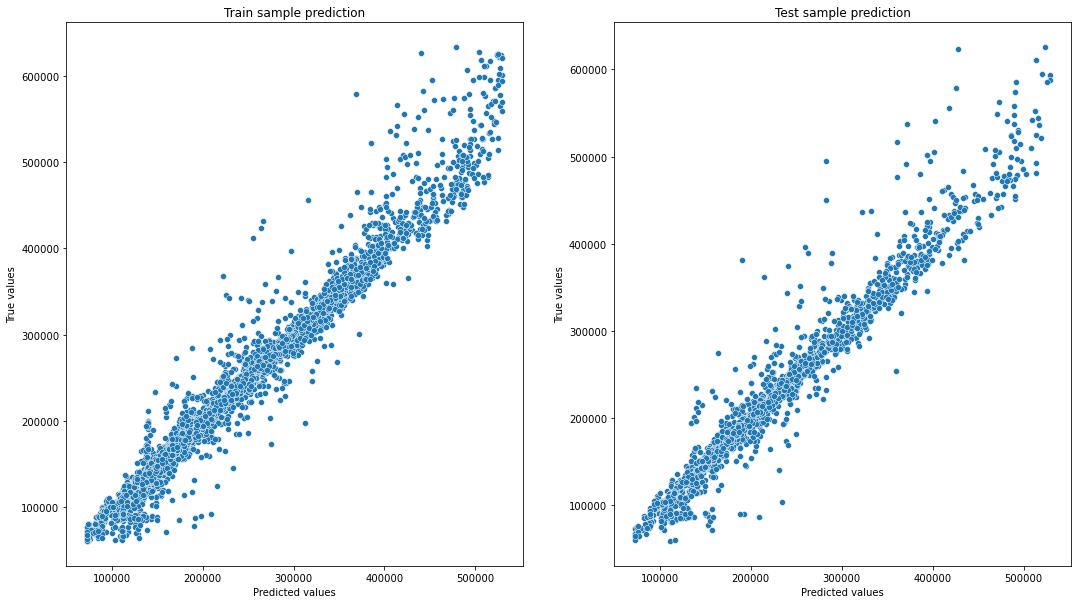

In [1052]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [1053]:
cv_score = cross_val_score(
    rf_model,
    X.fillna(-9999),
    y, scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=21)
)
cv_score

array([0.94804586, 0.95944702, 0.95825169, 0.96105569, 0.96485192])

In [1054]:
cv_score.mean(), cv_score.std()

(0.958330434748369, 0.005603253807154747)

In [1055]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.9527271809412142, 0.9639336885555237)

In [1056]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances['importance'] = round(feature_importances['importance'], 5)
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
18,MedPriceByDistrict,0.60610
19,SquarePrice,0.21243
1,Square,0.16854
3,KitchenSquare,0.00653
2,LifeSquare,0.00448
17,MedPriceByHouseYear,0.00082
5,HouseFloor,0.00068
13,Healthcare_1,0.00016
0,Rooms,0.00009
20,Renovated,0.00008


## Формирование файла с прогнозами

In [1057]:
test_df.shape

(5000, 23)

In [1058]:
pred_df = pd.DataFrame()
test_id = test_df["Id"]
pred_df["Id"] = test_id
pred_df["Price"] = rf_model.predict(test_df[feature_names + new_feature_names])
assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

pred_df.to_csv("./predictions_.csv", index=False)

In [1059]:
pred_df = pd.read_csv("./predictions_.csv")
pred_df.head(n=2)
print(pred_df['Price'].mean(), train_df['Price'].mean())

213496.78898845756 214020.359375


In [1060]:
test_df.shape[0]

5000